# PROJET IML

## Données

In [1]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
import sklearn
%matplotlib inline

In [2]:
# import de la donnée
arr_pines = np.load("./data/indianapines.npy")
arr_salinas = np.load("./data/salinas.npy")

In [3]:
# import de la vérité terrain
arr_pines_gt = np.load("./data/indianapines_gt.npy")
arr_salinas_gt = np.load("./data/salinas_gt.npy")

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.
Wikipedia donne :
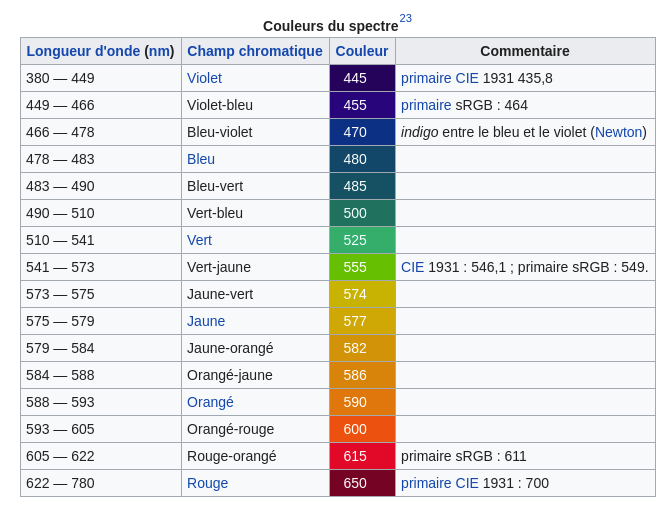

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [4]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)

In [27]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [28]:
def rgb_arr(arr):
    r = find_index_wavelength(611)
    g = find_index_wavelength(549)
    b = find_index_wavelength(464)
    return arr[:,:,[r, g, b]]

Text(0.5, 1.0, 'Reconstruction RGB Salinas')

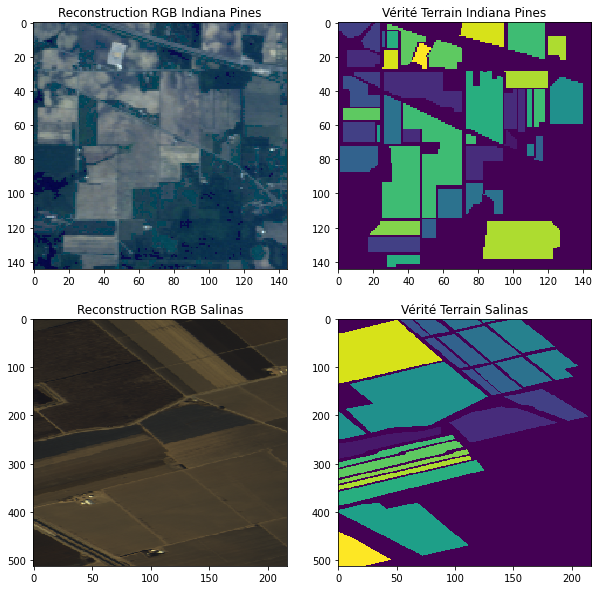

In [29]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0, 1].imshow(arr_pines_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1, 1].imshow(arr_salinas_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[0, 1].set_title("Vérité Terrain Indiana Pines")
axs[1, 1].set_title("Vérité Terrain Salinas")

axs[0, 0].imshow(normalize(rgb_arr(arr_pines)), cmap="viridis", aspect="auto", interpolation="none")
axs[1, 0].imshow(normalize(rgb_arr(arr_salinas)), cmap="viridis", aspect="auto", interpolation="none")
axs[0, 0].set_title("Reconstruction RGB Indiana Pines")
axs[1, 0].set_title("Reconstruction RGB Salinas")

In [30]:
labels = ["Unknown", "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", 
          "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean",
          "Wheat", "Woods", "Building-Grass-Tree-Drives", "Stone-Steel-Towers"]

## Watershed segmentation

In [31]:
arr = arr_pines

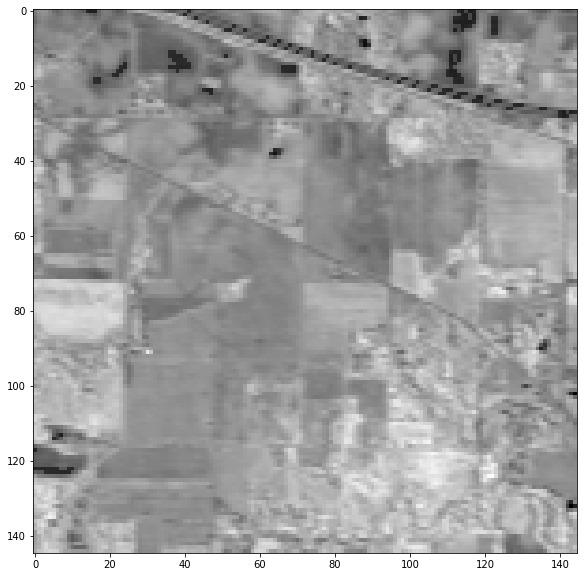

In [32]:
img = arr[:,:,65]
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")

In [33]:
from scipy import ndimage as ndi
from skimage.filters import rank
from skimage.morphology import ball, disk, square
from skimage.filters import sobel, roberts
from skimage.util import img_as_ubyte

In [34]:
grad = np.zeros_like(arr[:,:,0], dtype="int64")

for i in range(arr.shape[2]):
    band = arr[:,:,i]
    band = img_as_ubyte(band)
    denoised = rank.median(band, square(2))
    gradient = rank.gradient(denoised, square(2))
    grad += gradient

In [35]:
grad.min(), grad.max()

(0, 614)

In [36]:
grad = normalize(grad) * 255
# grad = skimage.morphology.closing(grad, selem=square(2))

(0.0, 255.0)

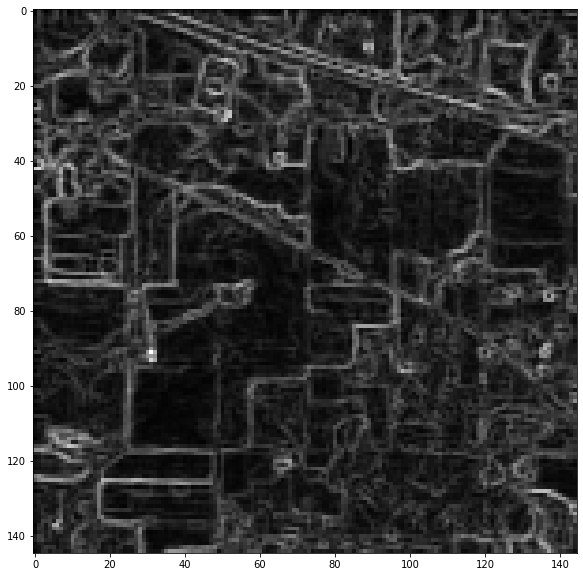

In [37]:
plt.figure(figsize = (10,10))
plt.imshow(grad, cmap="gray")
grad.min(), grad.max()

In [38]:
markers = grad < 40
markers = skimage.morphology.erosion(markers, selem=square(3))
markers = ndi.label(markers)[0]

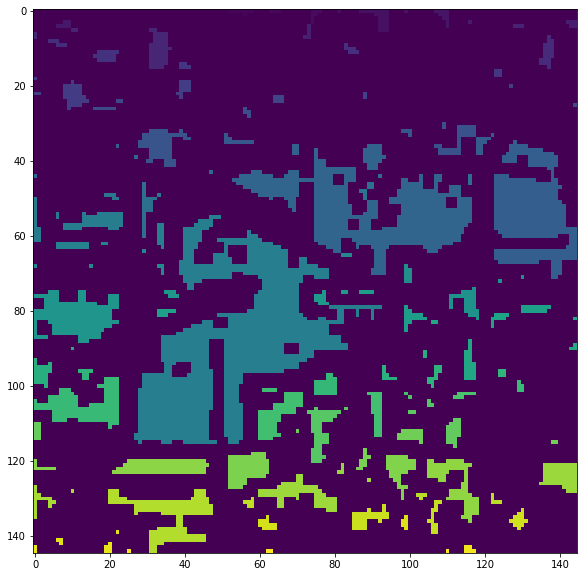

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(markers, cmap="viridis")

In [40]:
from skimage.segmentation import watershed
wshed = watershed(grad)

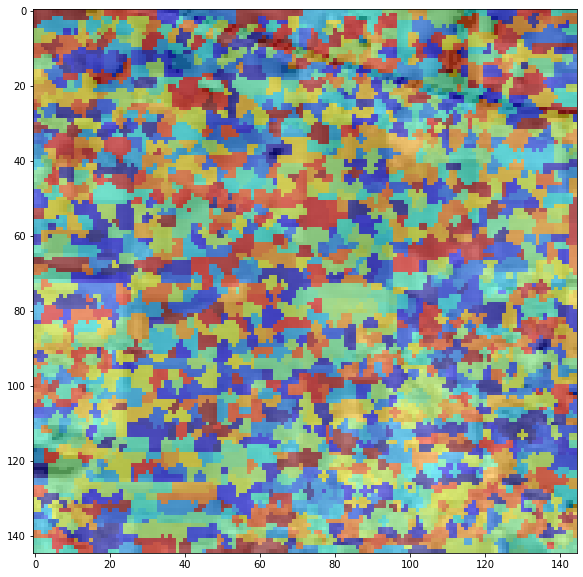

In [41]:
import numpy as np
import matplotlib.pyplot as plt
vals = np.linspace(0,1,1000)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))



plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")
plt.imshow(wshed, cmap=cmap, alpha=0.5)

In [43]:
len(np.unique(wshed))

2314

## Creation of train, test sets
We will first retrieve all the hyperspectral pixels and sort them according to their given class

In [351]:
arr = np.copy(arr_pines)
arr_gt = np.copy(arr_pines_gt)

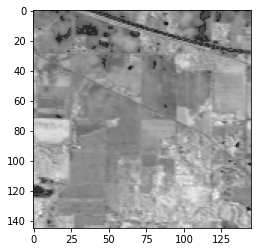

In [352]:
plt.imshow(arr[:,:,70], cmap = "gray")

In [353]:
for i in range(arr.shape[2]):
    band = arr[:,:,i]
    band = img_as_ubyte(band)
    arr[:,:,i] = rank.median(band, square(8))

In [354]:
# arr = np.resize(arr, (arr.shape[0], arr.shape[1], arr.shape[2] + 2))
indices = []
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        indices.append([i, j])
indices = np.array(indices)

In [355]:
dim = arr.shape[2]
from sklearn.model_selection import train_test_split
X = arr.reshape((-1, dim))
y = arr_gt.reshape((-1))

X = np.column_stack([X, indices])

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=42)

In [357]:
np.round(np.unique(y_train, return_counts=True)[1] / (y_train.shape[0]) * 100)

array([51.,  0.,  7.,  5.,  1.,  2.,  4.,  0.,  2.,  0.,  5., 10.,  3.,
        1.,  6.,  2.,  1.])

In [358]:
np.round(np.unique(y_test, return_counts=True)[1] / (y_test.shape[0]) * 100)

array([51.,  0.,  7.,  4.,  1.,  2.,  3.,  0.,  2.,  0.,  5., 12.,  3.,
        1.,  6.,  2.,  0.])

In [359]:
X_train.shape, y_train.shape

((3153, 202), (3153,))

In [360]:
X_train_indices = X_train[:,-2:]
X_test_indices = X_test[:, -2:]

In [361]:
X_test_indices

array([[127,  45],
       [ 56, 140],
       [ 32, 101],
       ...,
       [ 59,  23],
       [117,  93],
       [126, 126]])

In [362]:
X_train = X_train[:,:-2]
X_test = X_test[:, :-2]

## Preprocessing

## With `DecisionTreeClassifier`

In [363]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('pca', sklearn.decomposition.PCA(n_components=5)),
                       ('clf', DecisionTreeClassifier())])

In [364]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=5)),
                ('clf', DecisionTreeClassifier())])

In [365]:
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      9357
           1       0.44      0.31      0.37        48
           2       0.58      0.55      0.56      1280
           3       0.60      0.54      0.57       755
           4       0.40      0.36      0.38       219
           5       0.56      0.60      0.58       381
           6       0.49      0.49      0.49       627
           7       0.43      0.38      0.41        26
           8       0.85      0.85      0.85       405
           9       0.33      0.15      0.21        33
          10       0.61      0.61      0.61       832
          11       0.68      0.76      0.72      1923
          12       0.42      0.52      0.47       414
          13       0.81      0.73      0.77       191
          14       0.60      0.63      0.61      1007
          15       0.28      0.32      0.30       286
          16       0.74      0.64      0.68        88

    accuracy              

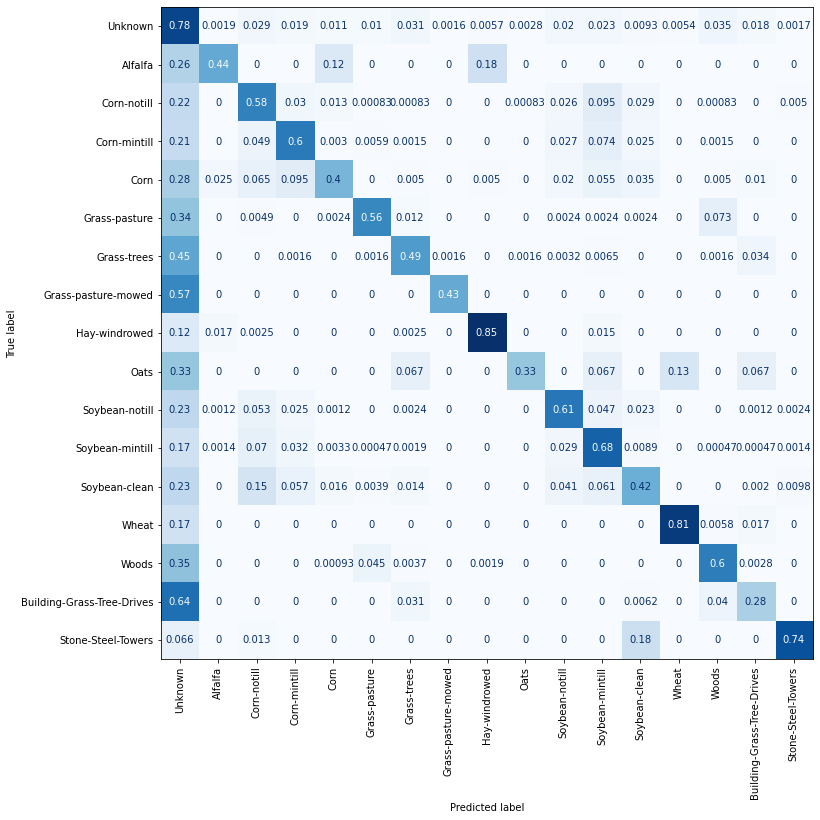

In [366]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(pipe, X_test, y_test, ax=ax, display_labels=labels,
                      xticks_rotation="vertical",normalize="true",
                     colorbar=False, cmap="Blues")
y_predicted = pipe.predict(X_test)
print(classification_report(y_predicted, y_test))

## Rebuilding the image from X_train and X_test

In [292]:
y = y.reshape(arr.shape[0], arr.shape[1])

In [293]:
y_rebuilt = np.ones_like(y)
for i in range(len(y_test)):
    h, w = X_test_indices[i]
    y_rebuilt[h, w] = y_predicted[i]
for i in range(len(y_train)):
    h, w = X_train_indices[i]
    y_rebuilt[h, w] = y_train[i]

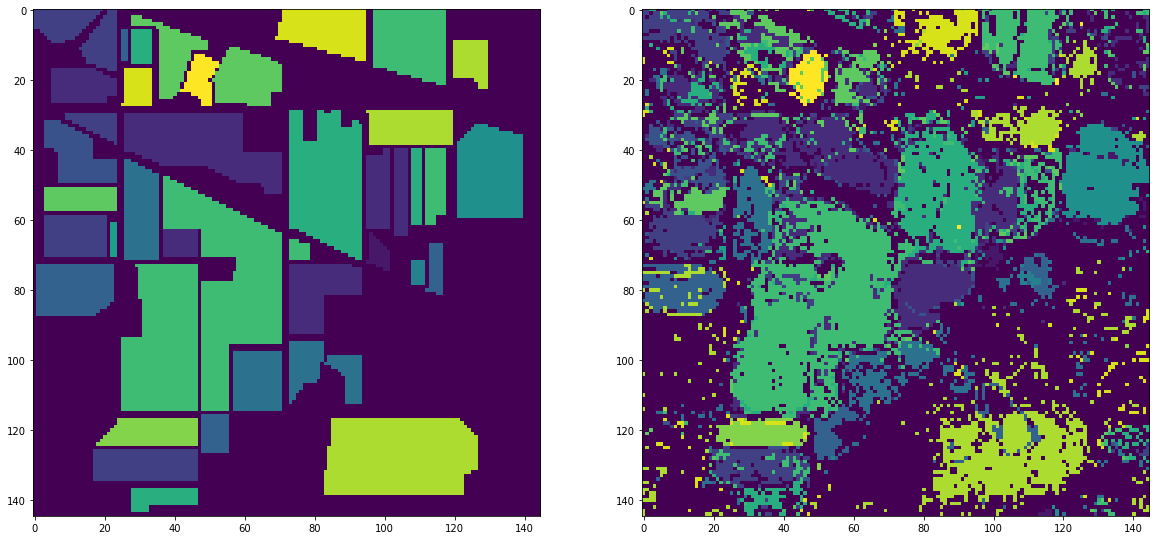

In [294]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(y)
ax2.imshow(y_rebuilt)

Using the watershed patches, the image is reconstructed using a majority voting scheme

In [269]:
patches = len(np.unique(wshed))
for patch in range(patches):
    ids, counts = np.unique(y_rebuilt[(wshed == patch)], return_counts=True)
    if (len(counts) != 0):
        y_rebuilt[(wshed == patch)] = ids[np.argmax(counts)]

In [270]:
import skimage
from skimage.morphology import opening, closing

def sharpenResult(result):
    my_result = result.copy()
    for i in range(1, result.max() + 1):
        classResult = my_result == i
        my_result[classResult] = 0
        

        
        classResult = skimage.morphology.remove_small_objects(classResult, 12)
        
        classResult = skimage.morphology.remove_small_holes(classResult, 8)
        classResult = skimage.morphology.closing(classResult, skimage.morphology.square(5))
        classResult = skimage.morphology.opening(classResult, skimage.morphology.square(3))
        
        my_result[classResult] = i
    return my_result

In [271]:
y_rebuilt = sharpenResult(y_rebuilt)

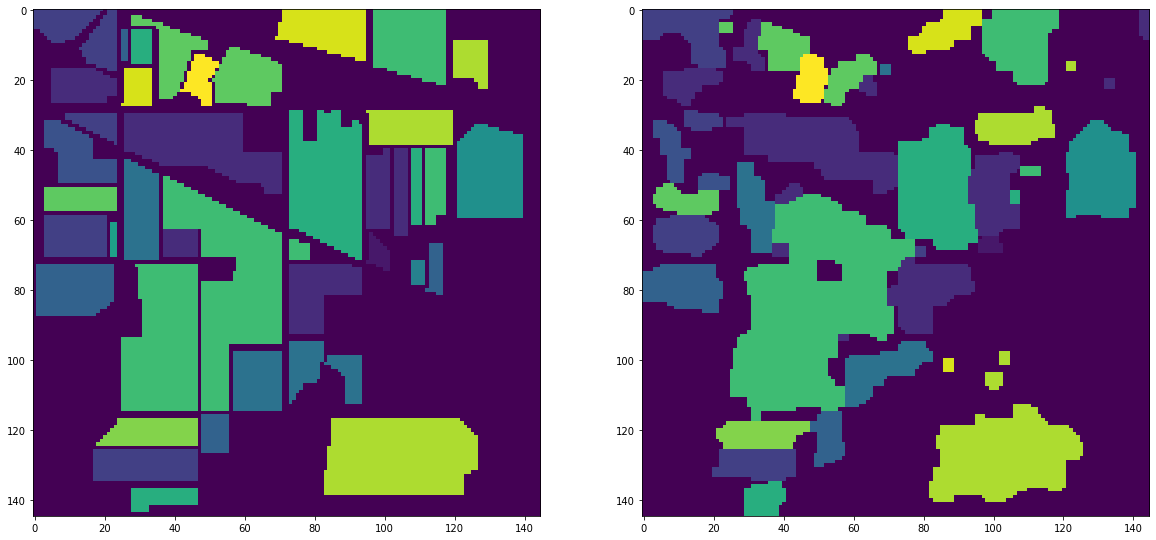

In [272]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(y)
ax2.imshow(y_rebuilt)

## Extract back y_predicted from the y_rebuilt

In [273]:
i = 0
for h, w in X_test_indices:
    y_predicted[i] = y_rebuilt[h, w]
    i += 1

              precision    recall  f1-score   support

           0       0.92      0.81      0.86     10397
           1       0.41      0.56      0.47        25
           2       0.83      0.77      0.80      1306
           3       0.77      0.91      0.84       573
           4       0.53      0.85      0.65       123
           5       0.67      0.84      0.74       322
           6       0.54      0.89      0.67       372
           7       0.00      1.00      0.00         0
           8       0.94      0.95      0.94       403
           9       0.00      1.00      0.00         0
          10       0.72      0.90      0.80       660
          11       0.85      0.89      0.87      2032
          12       0.57      0.86      0.69       339
          13       0.78      0.87      0.83       155
          14       0.78      0.89      0.83       935
          15       0.34      0.80      0.48       140
          16       0.88      0.74      0.81        90

    accuracy              

<AxesSubplot:>

<Figure size 1440x1440 with 0 Axes>

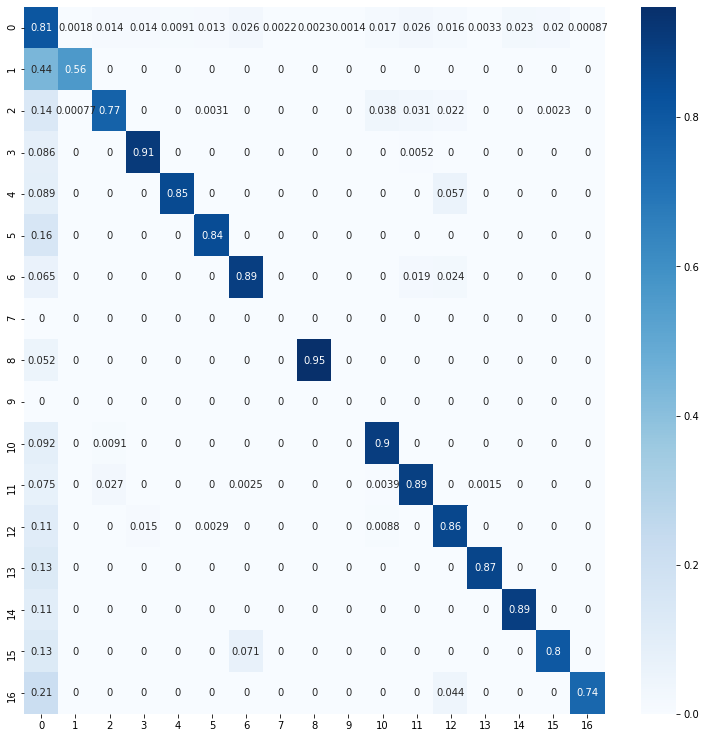

In [274]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


print(classification_report(y_predicted, y_test, zero_division=True))
matrix = confusion_matrix(y_predicted, y_test, normalize="true")
plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(matrix, annot=True, cmap='Blues',ax=ax)

### Show result

In [26]:
import skimage
from skimage.morphology import opening, closing

In [60]:
def showLabelisedImage(image, /, new_plot=False):
    if new_plot:
        plt.figure()
    plt.imshow(image, cmap="viridis")

def computeResult(image_input, pca, nb_comp):
    image = image_input.copy()
    image_flat = image.reshape((-1, image.shape[2]))
    image_pca = pca.transform(image_flat)[:,:nb_comp]
    y_predicted = clf.predict(image_pca)
    result = y_predicted.reshape(arr_pines.shape[:2])
    return result
    
def sharpenResult(result):
    my_result = result.copy()
    for i in range(1, result.max() + 1):
        classResult = my_result == i
        my_result[classResult] = 0
        
        plt.figure()
        plt.subplots(figsize=(15,15))

        plt.subplot(131)
        showLabelisedImage(classResult)
        
        classResult = skimage.morphology.remove_small_objects(classResult, 12)
        plt.subplot(132)
        showLabelisedImage(classResult)
        
        classResult = skimage.morphology.remove_small_holes(classResult, 8)
        classResult = skimage.morphology.closing(classResult, skimage.morphology.square(5))
        classResult = skimage.morphology.opening(classResult, skimage.morphology.square(3))
        plt.subplot(133)
        showLabelisedImage(classResult)
        
        my_result[classResult] = i
    return my_result

(16820,)


<ipython-input-60-a4602401e5e6>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


(16820,)

<Figure size 432x288 with 0 Axes>

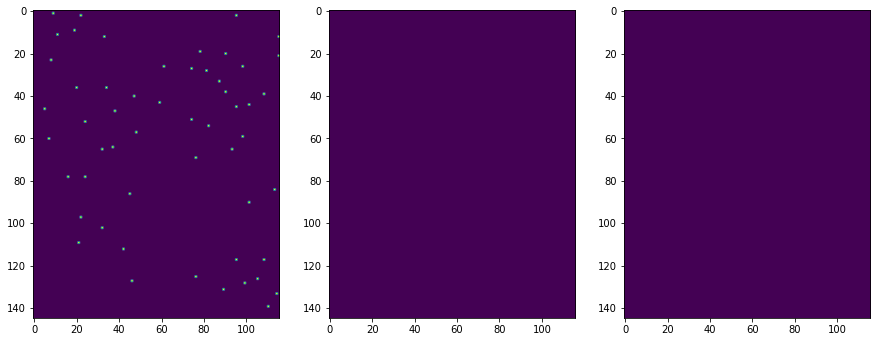

<Figure size 432x288 with 0 Axes>

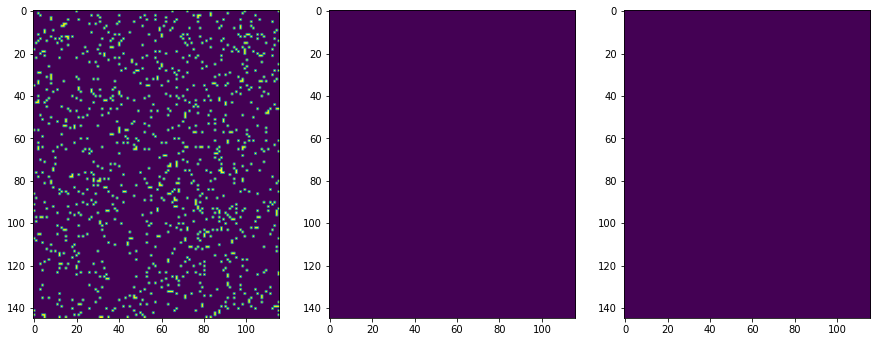

<Figure size 432x288 with 0 Axes>

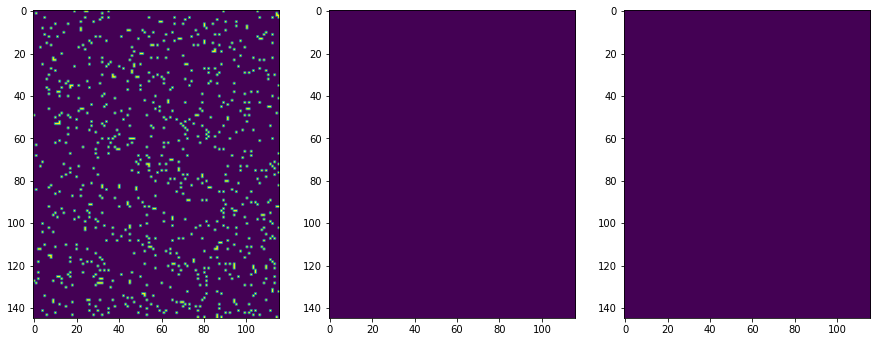

<Figure size 432x288 with 0 Axes>

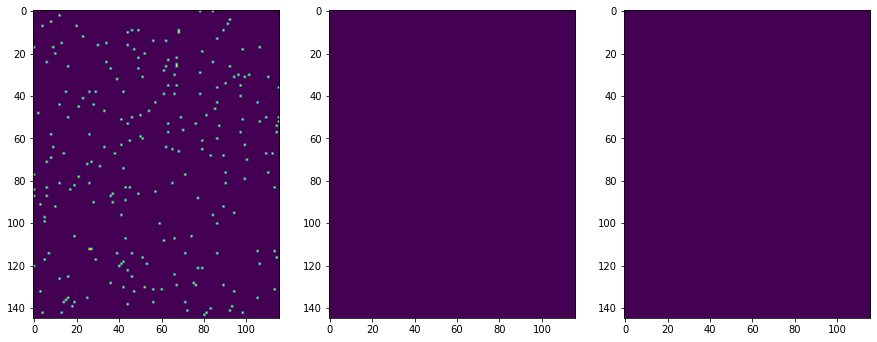

<Figure size 432x288 with 0 Axes>

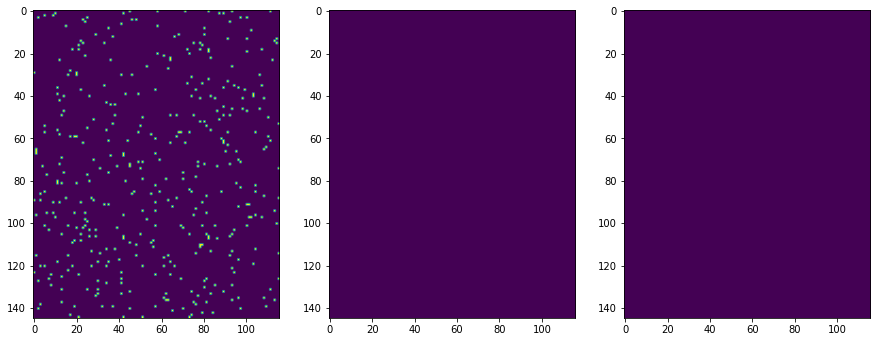

<Figure size 432x288 with 0 Axes>

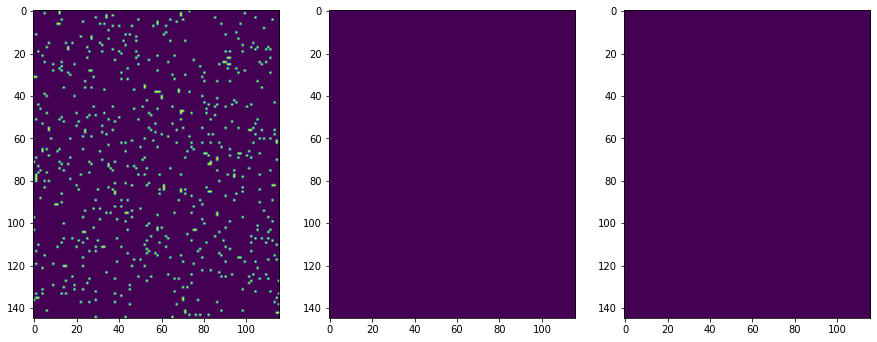

<Figure size 432x288 with 0 Axes>

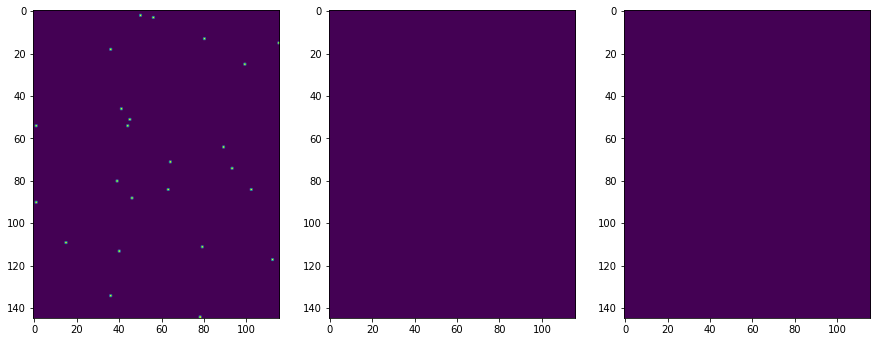

<Figure size 432x288 with 0 Axes>

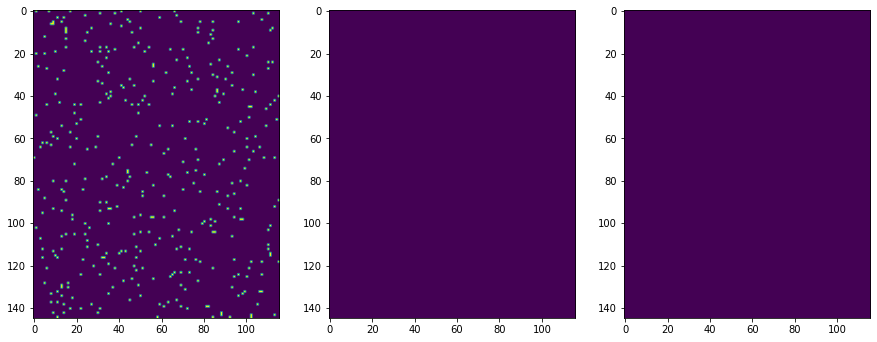

<Figure size 432x288 with 0 Axes>

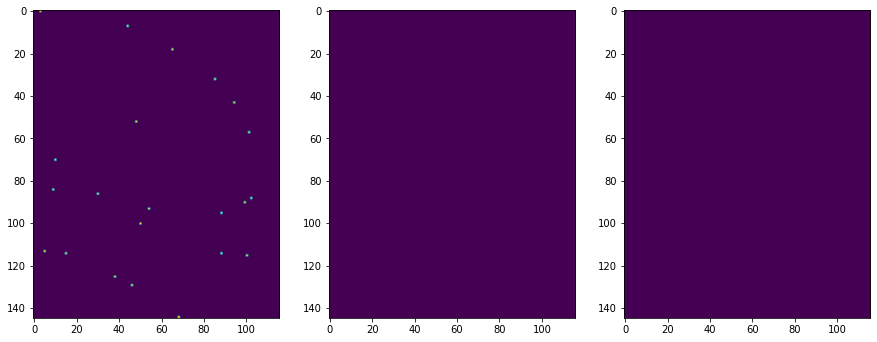

<Figure size 432x288 with 0 Axes>

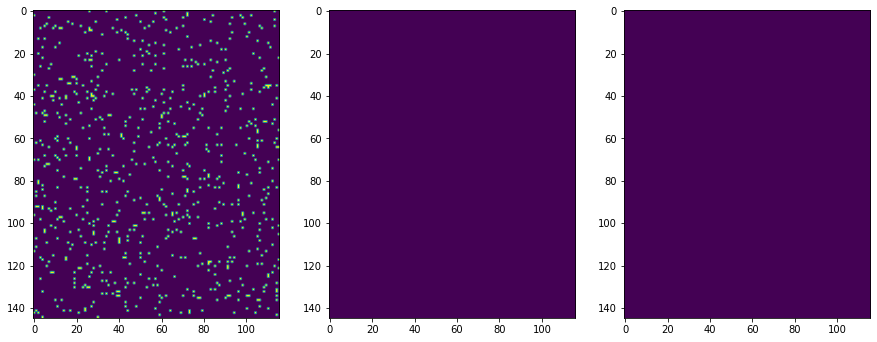

<Figure size 432x288 with 0 Axes>

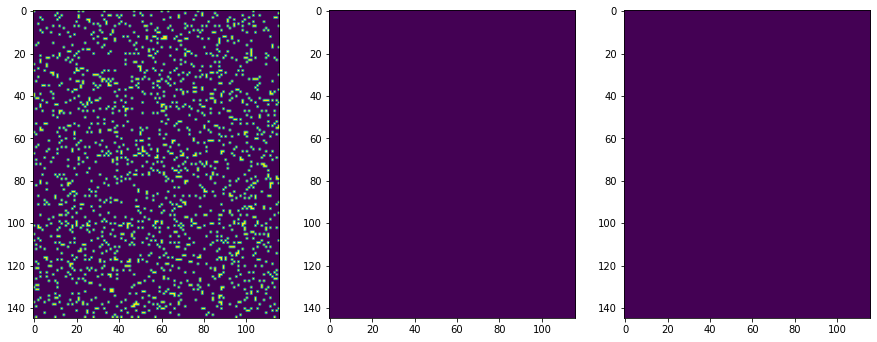

<Figure size 432x288 with 0 Axes>

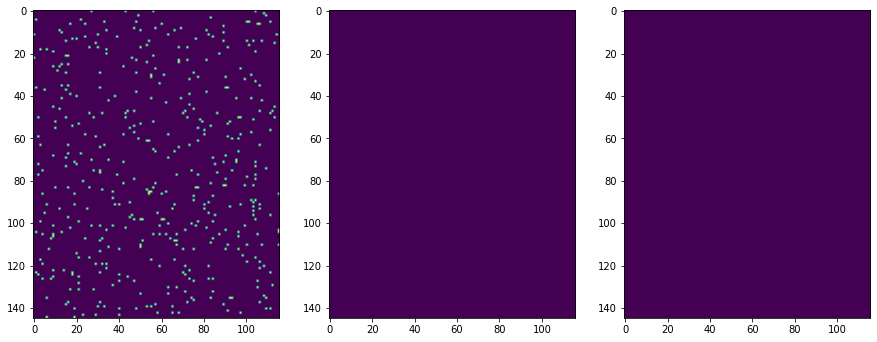

<Figure size 432x288 with 0 Axes>

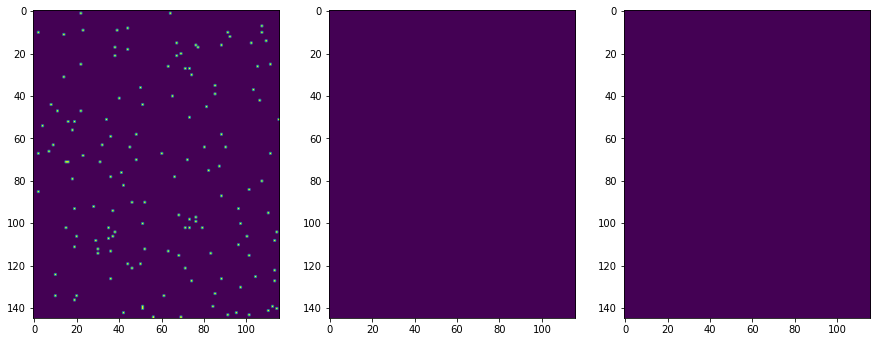

<Figure size 432x288 with 0 Axes>

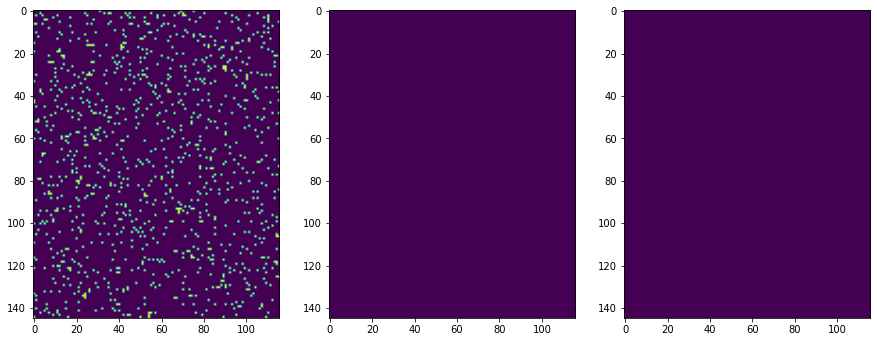

<Figure size 432x288 with 0 Axes>

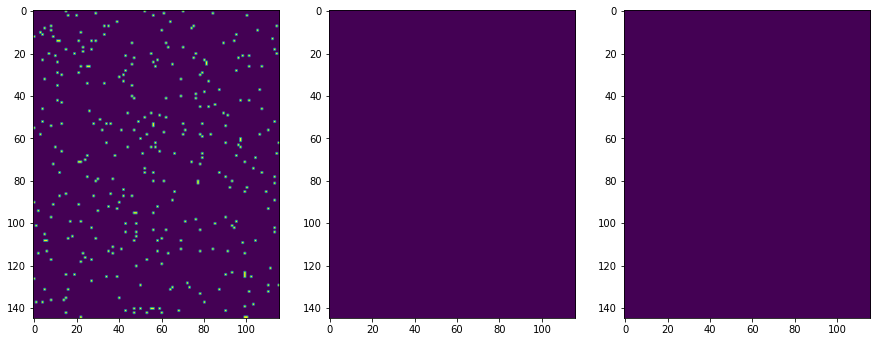

<Figure size 432x288 with 0 Axes>

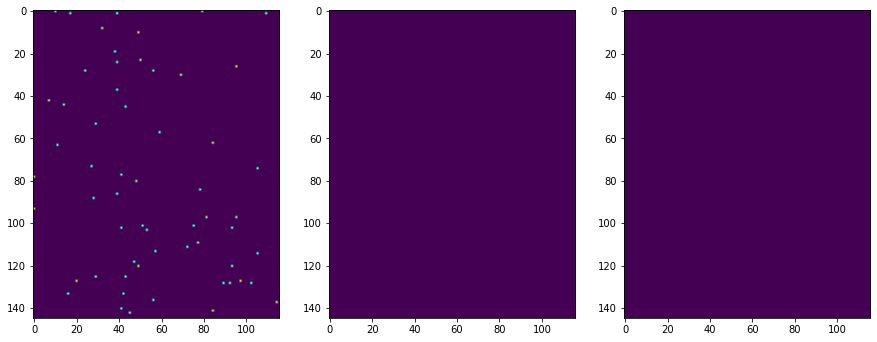

In [61]:
print(y_predicted.shape)
result = computeResult(arr_pines, pca, nb_comp)
sharpen_result = sharpenResult(y_predicted.reshape((145, 116)))
sharpen_result.reshape((-1)).shape
# Plot globally
# plt.subplots(figsize=(15,15))
# plt.subplot(131)
# showLabelisedImage(arr_pines_gt)
# plt.subplot(132)
# showLabelisedImage(result)
# plt.subplot(133)
# showLabelisedImage(sharpen_result)

In [58]:
sharpen_result = sharpen_result.reshape((-1))
sharpen_result.shape

(16820,)

In [59]:
print(classification_report(sharpen_result, y_test))

              precision    recall  f1-score   support

           0       1.00      0.51      0.68     16820
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0

    accuracy              

/home/dominique/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dominique/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dominique/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
tmp_img = sharpen_result.reshape((145, 116))

## Dimension reduction

In [ ]:
arr_pines_flat = arr_pines.reshape((-1, dim))
# X.reshape((row, col, dim)).shape

In [ ]:
Sigma = np.corrcoef(arr_pines_flat,rowvar=False)
plt.figure(figsize=(10,10))
plt.title('Correlation entre les données')
plt.imshow(Sigma)

In [ ]:
import sklearn.decomposition
pca_pines = sklearn.decomposition.PCA()
pca_pines.fit(arr_pines_flat)

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Explained variance per PC')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.subplot(122)
plt.title('Explained variance per PC (in log scale)')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.yscale('log')
plt.show()

In [ ]:
nb_comp = 10

In [ ]:
pines_projected = pca_hsi.transform(arr_pines_flat)
pines_projected_small = pines_projected[:,:nb_comp].reshape((row,col,10))

In [ ]:
plt.figure(figsize=(30,15))
for i in range(nb_comp):
    plt.subplot(2,5,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(pines_projected_small[:,:,i],cmap='gray')
plt.show()

In [ ]:
pines_projected_full = pines_projected.copy()
pines_projected_full[:,10:] = 0
pines_proj_back = pca_pines.inverse_transform(pines_projected_full).reshape((row,col,dim))

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(normalize(rgb_pines))
plt.subplot(122)
plt.imshow(normalize(pines_proj_back[:,:,[r, g, b]]))
plt.show()

In [ ]:
pines_projected_small.shape